# Relationship between num_modes and error for real complementary polynomials.

In general, when using fft_qsp, the error will increase the higher the degree of the input polynomial. In order to reduce the error, we can control the `num_modes` parameter which controls the number of frequencies used in the FFT. Increasing this parameter will reduce the error (but increase the number of calculations and the memory used.) Here we explore the how to find the ideal `num_modes`.

In [1]:
import numpy as np
import pytest

from qualtran.bloqs.for_testing.matrix_gate import MatrixGate

from qualtran.bloqs.qsp.fft_qsp import fft_complementary_polynomial
from qualtran.bloqs.qsp.generalized_qsp_test import verify_generalized_qsp
from qualtran.linalg.polynomial.qsp_testing import random_qsp_polynomial
from numpy.polynomial import Polynomial
from typing import List, Iterator, Sequence, Set, Tuple, TYPE_CHECKING, Union
from qualtran.symbolics import Shaped

import matplotlib.pyplot as plt

# This is similar to our check in fft_qsp_test.py, however, we return the error rather than asserting that the error is below a threshold.
def check_gqsp_polynomial_pair_on_random_points_on_unit_circle(
    P: Union[Sequence[complex], Polynomial, Shaped],
    Q: Union[Sequence[complex], Polynomial, Shaped],
    *,
    random_state: np.random.RandomState,
    n_points: int = 1000,
):

    P = Polynomial(P)
    Q = Polynomial(Q)

    z = np.exp(random_state.random(size=n_points) * np.pi * 2j)
    unity = np.abs(P(z)) ** 2 + np.abs(Q(z)) ** 2
    return max(abs(1-unity))

# The same check used in fft_qsp_test.py, but referencing our version of check_gqsp_polynomial_pair_on_random_points_on_unit_circle
def complimentary_polynomial_with_check(
    degree: int,  min_modes: int, only_real_coeffs:bool
):
    random_state = np.random.RandomState(42)
    tolerance = 1e-9
    P = random_qsp_polynomial(degree, random_state=random_state, only_real_coeffs=only_real_coeffs)
    Q = fft_complementary_polynomial(P, tolerance=tolerance, num_modes=min_modes)
    if only_real_coeffs:
        np.testing.assert_allclose(np.imag(Q), 0, atol=tolerance)
    return check_gqsp_polynomial_pair_on_random_points_on_unit_circle(
        P, Q, random_state=random_state, n_points=10000
    )



### Calculate the error for each combination of degrees and modes.

In [2]:
def complimentary_polynomial_error_search(degrees:List[int], only_real:bool=False):
    xyz = []
    for deg in degrees:
        for modes in range(100,300): # Experimentally, at least 9 modes are needed to get an error within a "ballpark" tolerance.
            result = complimentary_polynomial_with_check(deg, modes, only_real_coeffs=only_real)
            xyz.append([deg, modes, result])
    return np.array(xyz)
xyz = complimentary_polynomial_error_search(list(range(3,101)), only_real=True)


# How does the degree and num_modes relate to a given error cutoff point?

Here we create a grid showing each degree and num_modes used. We mark points that are over the tolerance threshold as red and those under the threshold as blue.

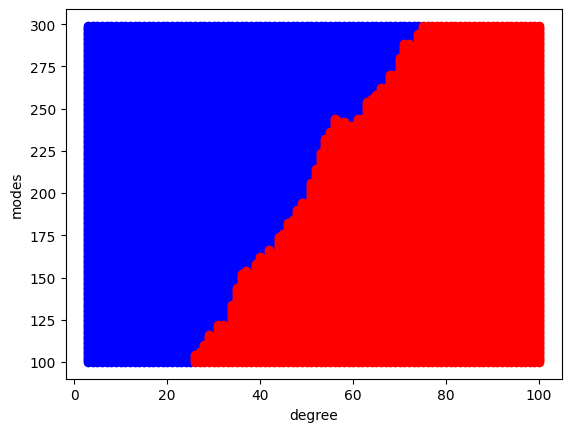

In [3]:
def plot_deg_vs_num_modes(xyz:np.ndarray, tol:float):
    good = np.where(xyz[:,2] < tol)
    bad = np.where(xyz[:,2] >= tol)
    plt.scatter(xyz[good,0], xyz[good,1], c='b')
    plt.scatter(xyz[bad,0], xyz[bad,1], c='r')
    plt.xlabel("degree")
    plt.ylabel("modes")
plot_deg_vs_num_modes(xyz,tol = 1e-9)

We look at the boundary between the red and blue.

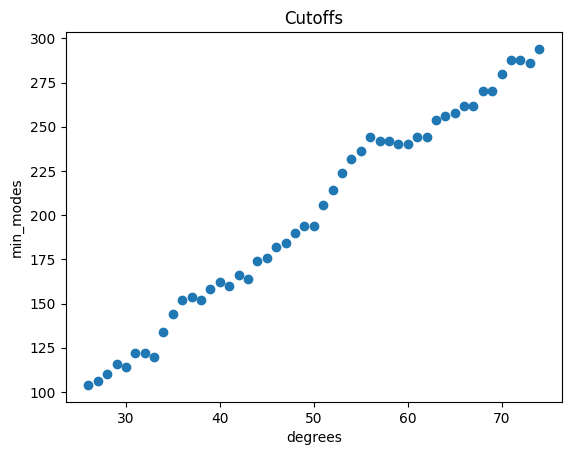

In [4]:
def plot_cutoff(xyz:np.ndarray, tol:float)->np.ndarray:
    results = []
    max_modes_in_dataset = np.max(xyz[:,1])

    for deg in set(xyz[:,0]):
        try:
            points_at_deg = xyz[np.where(xyz[:,0] == deg)]
            bad_points_at_deg = points_at_deg[np.where(points_at_deg[:,2] >= tol)]
            needed_modes = np.max(bad_points_at_deg[:,1])
            # We first make sure that we don't reach the maximum. 
            # We can only see points as high as what is in our dataset xyz.
            # Anything that hits the maximum is considered "off the chart" 
            # and is discarded.
            if needed_modes < max_modes_in_dataset:
                results.append([deg, needed_modes])
        except ValueError:
            continue
    results = np.array(results)
    
    plt.scatter(results[:,0],results[:,1])
    plt.xlabel("degrees")
    plt.ylabel("min_modes")
    plt.title("Cutoffs")
    plt.show()
    return results
cutoffs = plot_cutoff(xyz,tol = 1e-9)


It appears that the leftmost curve (going up to degree 35) remains consistent before noisiness takes over. This curve could likely be used as a conservative estimate for the number of modes needed.

In [5]:
!pip install scikit-learn


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


## Calculatte relationship cutoff point within the 95th percentile.

Slope:  [2.75] const:  90.0


/home/linux_environment/miniconda3/envs/quantum/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


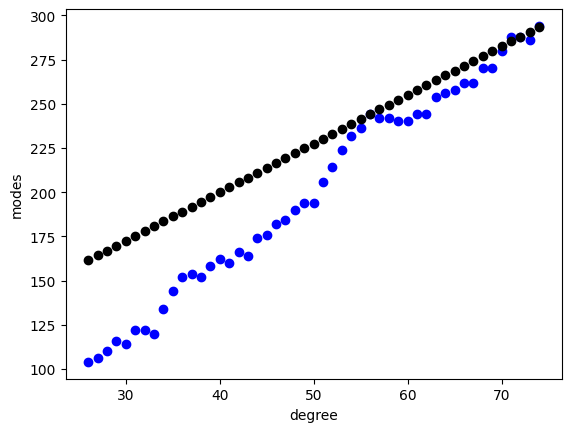

In [6]:
from sklearn.linear_model import QuantileRegressor
from sklearn.utils.fixes import parse_version, sp_version

def _clean_array(array: np.ndarray):
    if len(array.shape) == 1:
        array = np.expand_dims(array,1)
    return np.array(array,dtype=np.float32)

def regression_with_confidence_interval(X, Y,quantile=.95):
    """
    Here X is (log(error), degree). Y is num_modes.
    """
    qr = QuantileRegressor(quantile=quantile)
    solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"
    X = _clean_array(X)
    Y = _clean_array(Y)
    qr.fit(X,Y)
    
    fx = qr.predict(X)


    plt.scatter(X,Y,c='b')
    plt.scatter(X,fx,c='k')
    plt.xlabel("degree")
    plt.ylabel("modes")
    print("Slope: ",qr.coef_, "const: ",qr.intercept_)

regression_with_confidence_interval(cutoffs[:,0], cutoffs[:,1], quantile=.95)

## Understanding error vs num_modes and degree

Here, we plot how error changes by num_modes

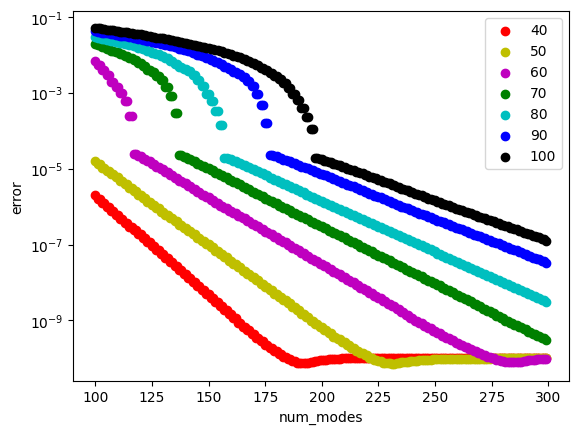

In [7]:
COLORS = ['r','y','m','g','c','b','k']
degrees = [40,50,60,70,80,90,100]
for i in range(len(degrees)):
    degree = np.where(xyz[:,0] == degrees[i])

    plt.scatter(xyz[degree,1], xyz[degree,2], c=COLORS[i])
    plt.xlabel("num_modes")
    plt.ylabel("error")
    plt.yscale("log")
plt.legend(degrees)


We look at a single plot on a linear scale.

Text(0.5, 1.0, 'Plot for degree: 40')

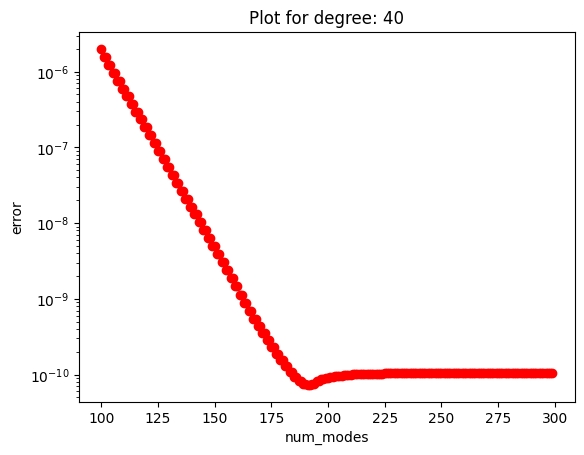

In [8]:
DEG = 40
degree = np.where(xyz[:,0] == DEG)

plt.scatter(xyz[degree,1], xyz[degree,2], c=COLORS[0])
plt.xlabel("num_modes")
plt.ylabel("error")
plt.yscale("log")
plt.title("Plot for degree: "+str(DEG))


A grough estimate of the plots above shows that the point at which the error curve flattens is roughly between `4*deg` and `5*deg`.

# Here we repeat the above process for complex polynomials

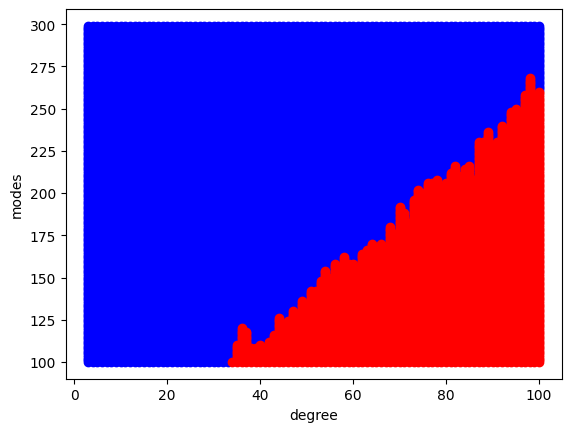

In [9]:
xyz_complex = complimentary_polynomial_error_search(list(range(3,101)), only_real=False)
plot_deg_vs_num_modes(xyz_complex,tol=1e-9)

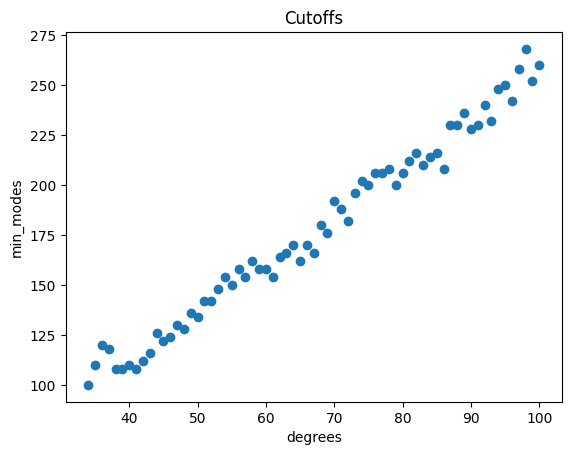

Slope:  [2.20689655] const:  40.551724137931025


/home/linux_environment/miniconda3/envs/quantum/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


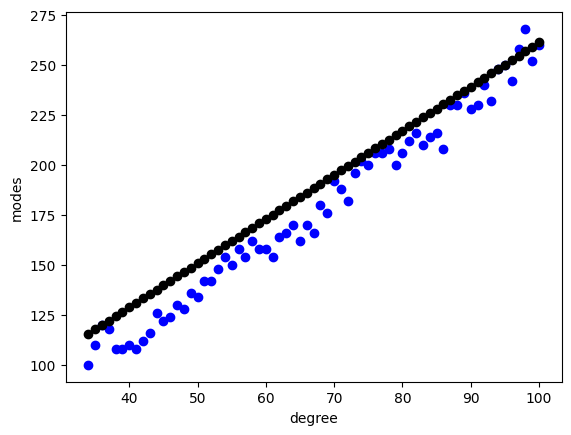

In [10]:
cutoffs_complex =  plot_cutoff(xyz_complex,tol = 1e-9)
regression_with_confidence_interval(cutoffs_complex[:,0], cutoffs_complex[:,1], quantile=.95)

## Result 

Looking at the results for real and for complex polynomials, the real value tends to be the more conservative result. We will go by this estimate.


Given the conservative estimate (for real polynomials) the cutoff can be estimated (within a 95% confidence interval up to degree 100) $$ y > 2.75x+90.0 $$

# Notes

A further exploration of how error changes with num_modes

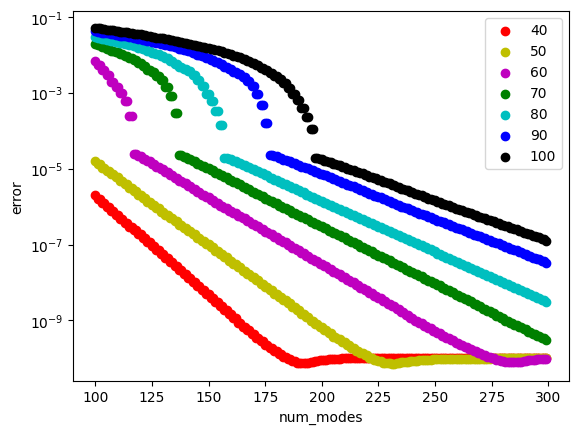

In [11]:
COLORS = ['r','y','m','g','c','b','k']
degrees = [40,50,60,70,80,90,100]
for i in range(len(degrees)):
    degree = np.where(xyz[:,0] == degrees[i])

    plt.scatter(xyz[degree,1], xyz[degree,2], c=COLORS[i])
    plt.xlabel("num_modes")
    plt.ylabel("error")
    plt.yscale("log")
plt.legend(degrees)
